## Plotting Prediction Intervals for Time Series Projects

**Author**: Lukas Innig

**Label**: TIme Series

### Scope
The scope of this notebook is to provide instructions on how to plot prediction intervals for time series projects. This script will work for both multi and single time series projects.

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

It is assumed you already have a DataRobot Time Series <code>Project</code> object.

#### Import Libraries

In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

#### Connect to DR, Define Project and Model

Make sure you pick a model other than "Recommended for Deployment" as there is no backtesting calculations for that model. You will also need to **load the dataset you used to create the project** in a pandas dataframe called <code>data</code>

In [2]:
dr.Client(token = 'YOUR_API_KEY',
         endpoint = 'YOUR_HOSTNAME')

data = pd.read_excel('path/to/file') #The data that was used for the project. change pd.read_ method according to file type

project = project = dr.Project.get('YOUR_PROJECT_ID') #Use this with project ID to get your project.
model = [m for m in project.get_models()][1] #You can choose whichever model you wish other than the recommended for deployment

#### Define function that returns training predictions
Below function might take a while to finish running

In [3]:
def get_training_predictions(model):
    print(f"calculating training predictions for {model.model_type}")
    try:
        backtests_pred_job = model.request_training_predictions(data_subset=dr.enums.DATA_SUBSET.ALL_BACKTESTS)
        backtests_pred_job.wait_for_completion()
        backtest_predictions = backtests_pred_job.get_result_when_complete().get_all_as_dataframe()
    except:
        pass
    try:  
        holdout_pred_job = model.request_training_predictions(data_subset=dr.enums.DATA_SUBSET.HOLDOUT)
        holdout_pred_job.wait_for_completion()
        holdout_predictions = holdout_pred_job.get_result_when_complete().get_all_as_dataframe()
    except:
        pass
    all_predictions = dr.TrainingPredictions.list(model.project_id)

    my_model_training_predictions = [p for p in all_predictions if p.model_id == model.id]
    all_prediction_frames = [p.get_all_as_dataframe() for p in my_model_training_predictions]
    if 'Holdout' in all_prediction_frames[0].partition_id.unique():
        holdout_predictions = all_prediction_frames[0]
        backtest_predictions = all_prediction_frames[1]
    else:
        holdout_predictions = all_prediction_frames[1]
        backtest_predictions = all_prediction_frames[0]
    return backtest_predictions, holdout_predictions

In [4]:
backtest_predictions, holdout_predictions = get_training_predictions(model)

calculating training predictions for eXtreme Gradient Boosted Trees Regressor with Early Stopping


#### Get partitioning information
The script will figure out automatically if this is a single series or a multiseries project.

In [5]:
partitioning = dr.DatetimePartitioning.get(project.id)

try:
    series_id_column = partitioning.multiseries_id_columns[0].replace(' (actual)','')
    is_multiseries = True
except:
    is_multiseries = False
    print('This seems to be a single Series Project')
    
date_column = partitioning.datetime_partition_column.replace(' (actual)','')
target_column = project.target.replace(' (actual)','')

#### Define function that calculates errors
Between predictions made by DataRobot and actual values (with intervals).

In [6]:
def calculate_errors(backtest_preds, holdout_preds):
    holdout_preds['timestamp'] = pd.to_datetime(holdout_preds['timestamp'], utc=False).dt.tz_localize(None)
    holdout_preds['forecast_point'] = pd.to_datetime(holdout_preds['forecast_point'], utc=False).dt.tz_localize(None)
    
    if is_multiseries == True:
        holdout_preds.rename(columns={'series_id':series_id_column, 'timestamp':date_column}, inplace=True)
    else:
        holdout_preds.rename(columns={'timestamp':date_column}, inplace=True)
        
    backtest_preds['timestamp'] = pd.to_datetime(backtest_preds['timestamp'], utc=False).dt.tz_localize(None)
    backtest_preds['forecast_point'] = pd.to_datetime(backtest_preds['forecast_point'], utc=False).dt.tz_localize(None)
    
    if is_multiseries == True:
        backtest_preds.rename(columns={'series_id':series_id_column, 'timestamp':date_column}, inplace=True)
    else:
        backtest_preds.rename(columns={'timestamp':date_column}, inplace=True)
    
    if is_multiseries == True:
        holdout_preds_joined = holdout_preds.set_index([date_column, series_id_column]).join(data.set_index([date_column, series_id_column])).reset_index()
        backtest_preds_joined = backtest_preds.set_index([date_column, series_id_column]).join(data.set_index([date_column, series_id_column])).reset_index()
    else:
        holdout_preds_joined = holdout_preds.set_index([date_column]).join(data.set_index([date_column])).reset_index()
        backtest_preds_joined = backtest_preds.set_index([date_column]).join(data.set_index([date_column])).reset_index()
    
    if is_multiseries == True:
        errors = backtest_preds_joined.groupby(['forecast_distance', series_id_column])[['prediction', target_column]].apply(lambda df: pd.Series(np.abs(df['prediction'] - df[target_column]).std()))

        errors.columns=['prediction_interval']
        holdout_preds_joined = holdout_preds_joined.set_index(['forecast_distance',series_id_column]).join(errors).reset_index()
    else:
        errors = backtest_preds_joined.groupby(['forecast_distance'])[['prediction', target_column]].apply(lambda df: pd.Series(np.abs(df['prediction'] - df[target_column]).std()))

        errors.columns=['prediction_interval']
        holdout_preds_joined = holdout_preds_joined.set_index(['forecast_distance']).join(errors).reset_index()

    holdout_preds_joined['error_high'] = holdout_preds_joined['prediction'] + 2*holdout_preds_joined['prediction_interval']
    holdout_preds_joined['error_low'] = holdout_preds_joined['prediction'] - 2*holdout_preds_joined['prediction_interval']
    return holdout_preds_joined

In [10]:
prediction_data = calculate_errors(backtest_predictions, holdout_predictions)

#### Define function to plot prediction intervals

In [8]:
def plot_predictions(prediction_data, data, forecast_point, history):
    if is_multiseries == True:
        n_cols = data[series_id_column].drop_duplicates().shape[0]//2
        fig, axs = plt.subplots(n_cols,2, figsize=(20,30))
        plot_counter = 1
        for c, df in prediction_data.groupby(series_id_column):
            ax = plt.subplot(n_cols,2,plot_counter)
            plot_counter += 1
            pred_data_plot = df[df.forecast_point == forecast_point]
            all_data_plot = data.loc[(data[series_id_column] == c) & (data.Date > pd.to_datetime(forecast_point) - history)]

            g = sns.lineplot(data=pred_data_plot, x='Date', y='prediction', label='Prediction', color='green', linewidth=3)
            ax.fill_between(pred_data_plot.Date.values, pred_data_plot.error_low, pred_data_plot.error_high, alpha=0.3, zorder=-10, color='lightgreen')

            #sns.lineplot(data=df, x='Date', y='target')
            g = sns.lineplot(data=all_data_plot[all_data_plot.Date <= forecast_point], x='Date', y=target_column, linewidth=3, color='blue', label='Actual')
            g = sns.lineplot(data=all_data_plot[all_data_plot.Date > forecast_point], x='Date', y=target_column, linewidth=3, color='blue')
            g.lines[2].set_linestyle("--")
            ax.axvline(forecast_point, linestyle='--', c='gray')

            plt.xticks(rotation=45, ha='right')
            plt.title(c)
            #plt.show()
        plt.tight_layout()
        return fig
    else:
        df = prediction_data
        fig, axs = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,1,1)
        pred_data_plot = df[df.forecast_point == forecast_point]
        all_data_plot = data.loc[(data.Date > pd.to_datetime(forecast_point) - history)]

        g = sns.lineplot(data=pred_data_plot, x='Date', y='prediction', label='Prediction', color='green', linewidth=3)
        ax.fill_between(pred_data_plot.Date.values, pred_data_plot.error_low, pred_data_plot.error_high, alpha=0.3, zorder=-10, color='lightgreen')

        #sns.lineplot(data=df, x='Date', y='target')
        g = sns.lineplot(data=all_data_plot[all_data_plot.Date <= forecast_point], x='Date', y=target_column, linewidth=3, color='blue', label='Actual')
        g = sns.lineplot(data=all_data_plot[all_data_plot.Date > forecast_point], x='Date', y=target_column, linewidth=3, color='blue')
        g.lines[2].set_linestyle("--")
        ax.axvline(forecast_point, linestyle='--', c='gray')

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

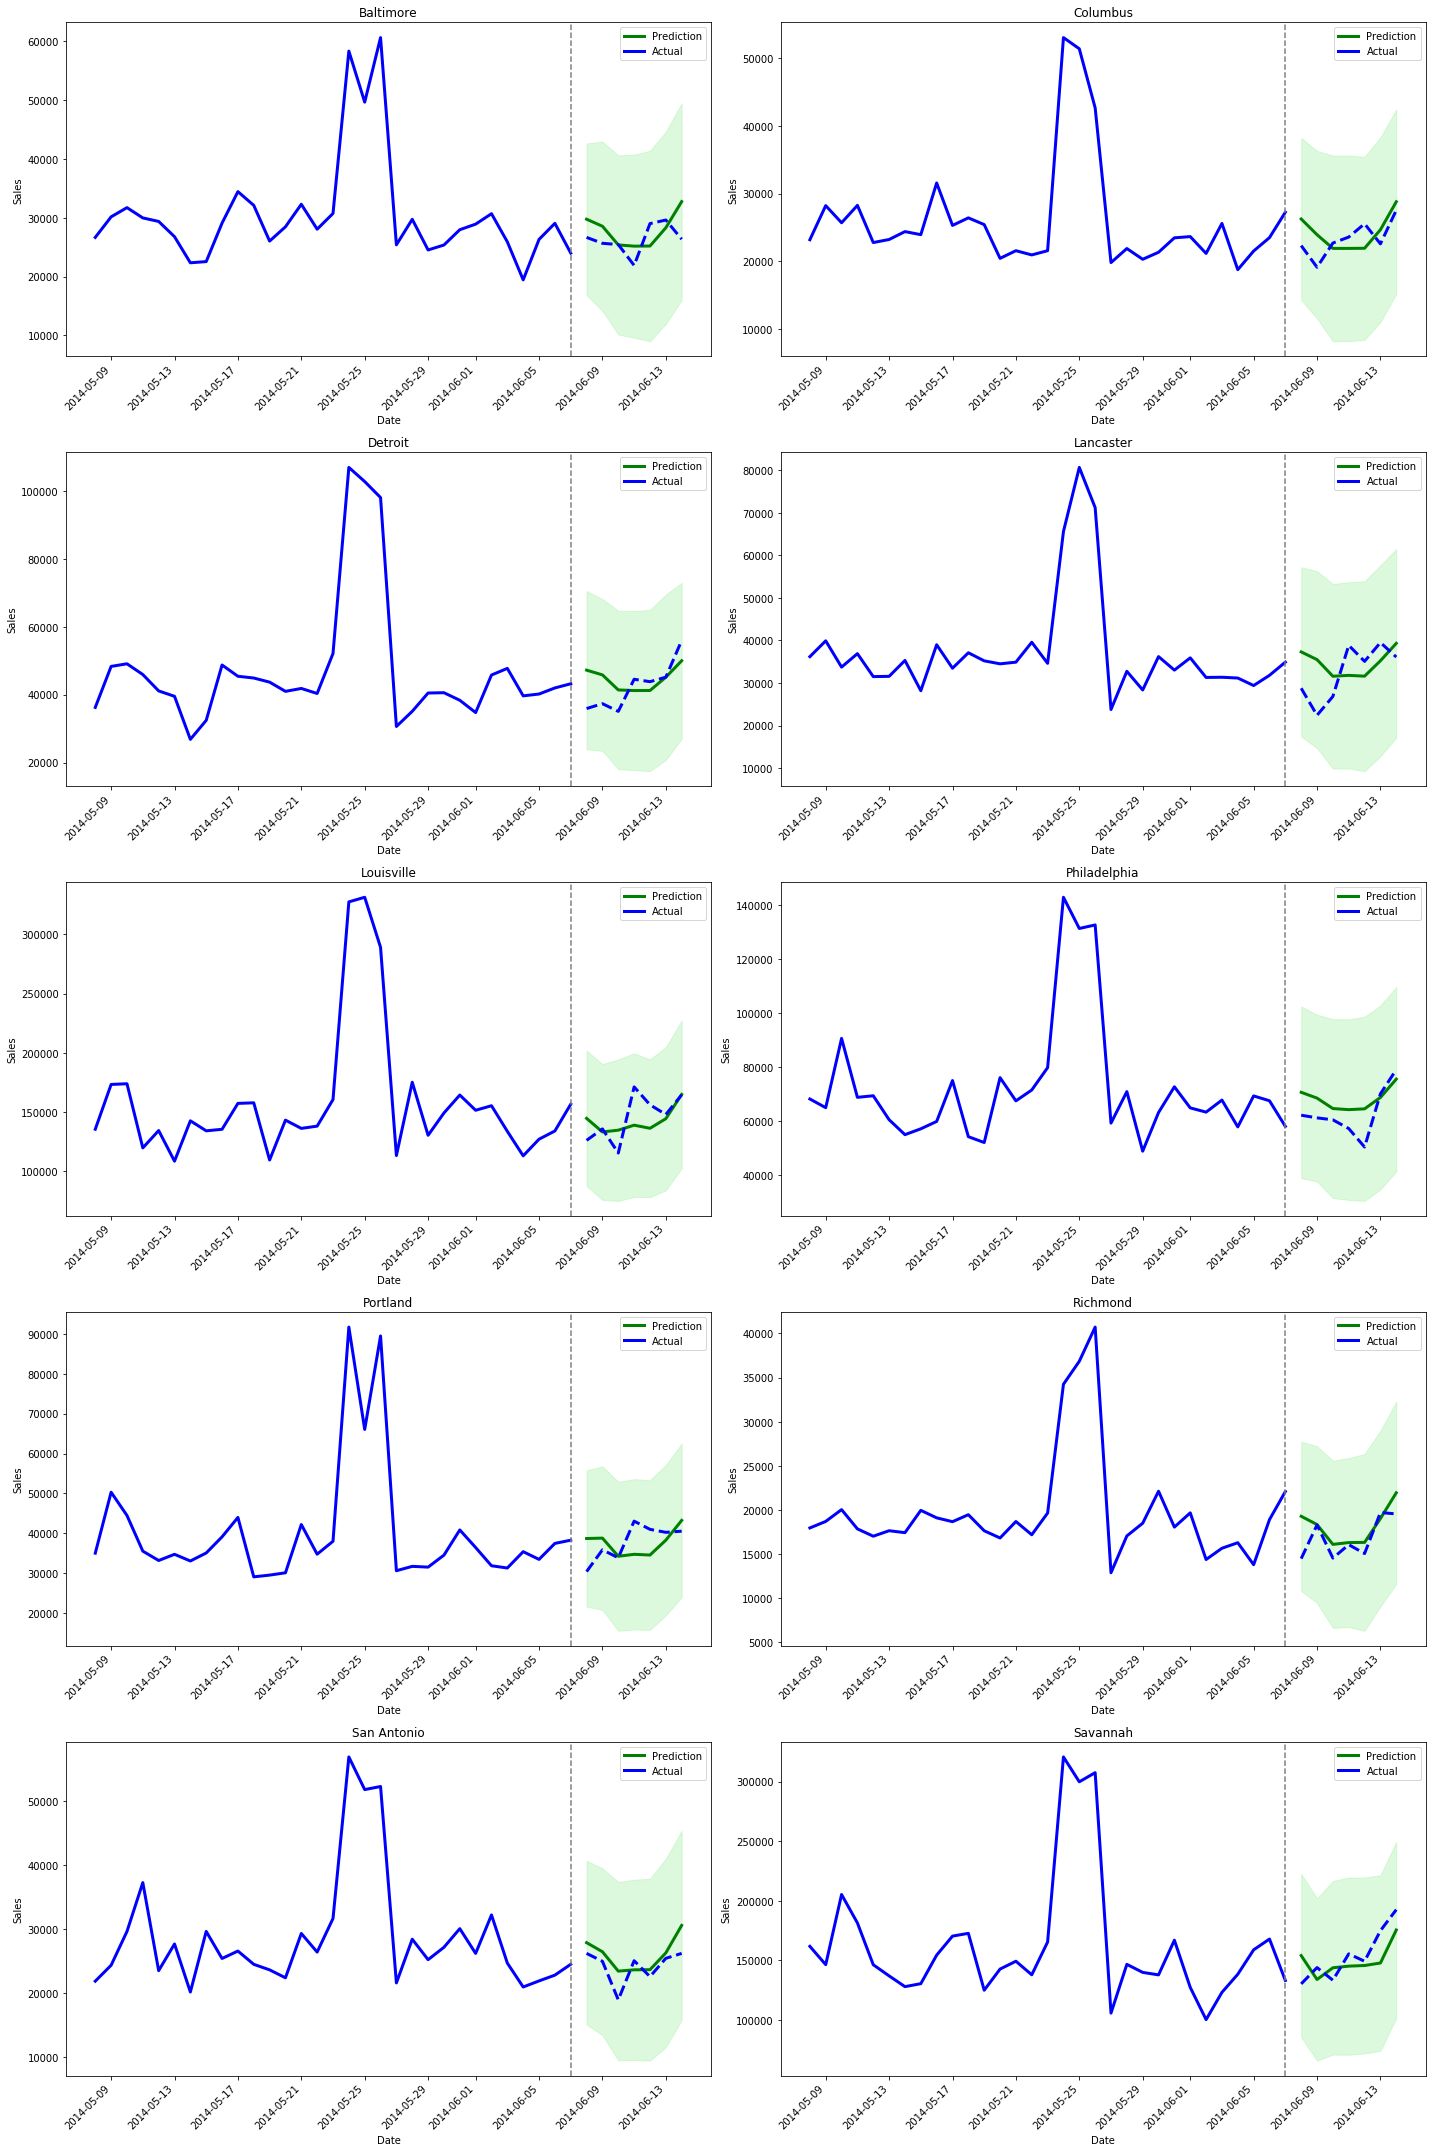

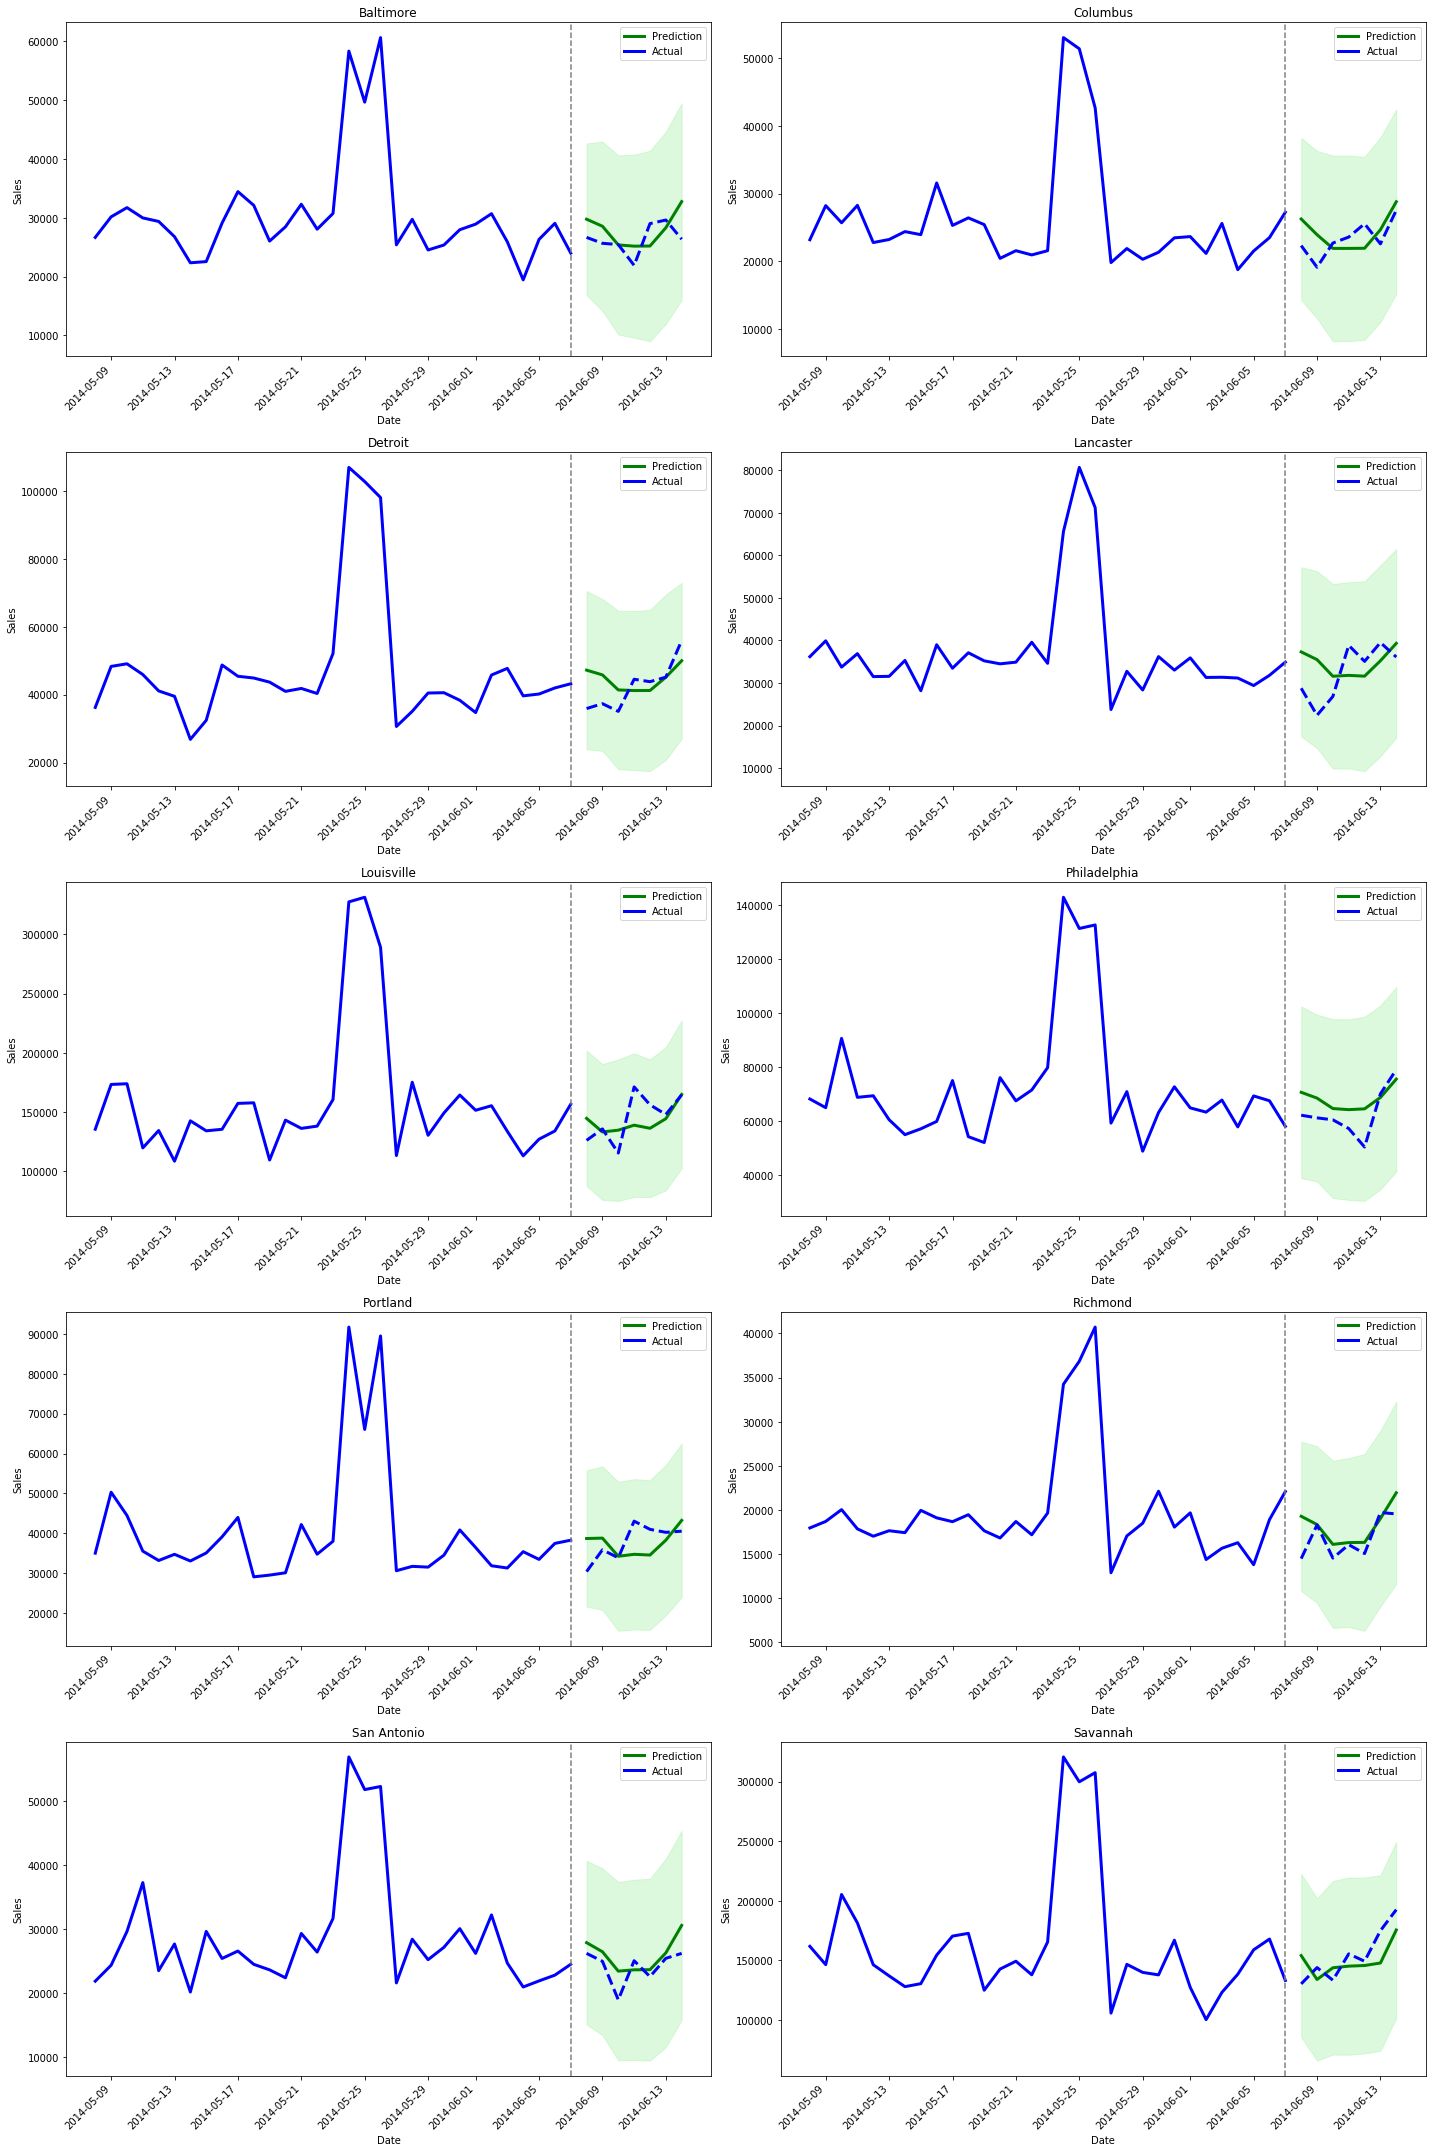

In [9]:
plot_predictions(prediction_data, data, forecast_point='2014-06-07', history=pd.Timedelta(1, 'M'))